# Предсказание цен на автомобили

Задача - на основе данных о продажах автомобилей с пробегом (технические характеристики, комплектации и цены и т.д.) обучить несколько моделей машинного обучения и определить самую эффективную, исходя из следующих параметров: время обучения, скорость предсказания и качество предсказания (rmse).
Выбранная модель предназначена для использования в интернет-сервисах по продаже подержанных автомобилей как помощник для определения цены.

## Импорт библиотек

In [117]:
! pip install -q CatBoost

In [118]:
import pandas as pd
import numpy as np
import time

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import make_scorer

from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
def rmse(y_true, y_pred):
    return mse(y_true, y_pred)**0.5

In [120]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

Создадим пустой список, он пригодиться для сравнения моделей в конце работы.

In [121]:
compare_data = [[], [], [], [], [], []]

## Подготовка данных

In [122]:
df = pd.read_csv('/content/drive/MyDrive/Practicum_projects/\
Car_Prices/autos.csv')

In [123]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [124]:
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [126]:
df.isna().mean()

date_crawled          0.000000
price                 0.000000
vehicle_type          0.105794
registration_year     0.000000
gearbox               0.055967
power                 0.000000
model                 0.055606
kilometer             0.000000
registration_month    0.000000
fuel_type             0.092827
brand                 0.000000
not_repaired          0.200791
date_created          0.000000
number_of_pictures    0.000000
postal_code           0.000000
last_seen             0.000000
dtype: float64

In [127]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [128]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

In [129]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [130]:
df.describe(include='object')

,date_crawled,vehicle_type,gearbox,model,fuel_type,brand,not_repaired,date_created,last_seen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


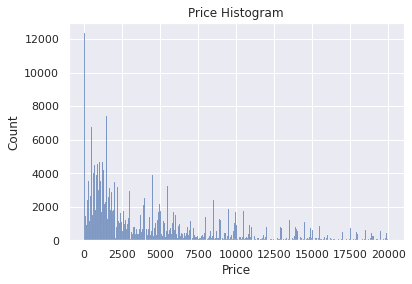

In [131]:
a = sns.histplot(df, x='price', bins=500)
a.set(xlabel='Price', ylabel='Count', 
      title='Price Histogram')
plt.show()

In [132]:
df = df[df['price'] > 100]

In [133]:
df = df[df['registration_year'] > 1900]
df = df[df['registration_year'] < 2017]

In [134]:
df = df[df['power'] > 10]
df = df[df['power'] < 1000]

In [135]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,294628.000000,294628.000000,294628.000000,294628.000000,294628.00000,294628.0,294628.000000
mean,4884.654184,2002.841149,120.959043,128287.908821,6.00241,0.0,51245.781362
std,4611.705042,6.539735,54.620277,36716.886257,3.57936,0.0,25766.893690
min,101.000000,1910.000000,11.000000,5000.000000,0.00000,0.0,1067.000000
25%,1350.000000,1999.000000,77.000000,125000.000000,3.00000,0.0,30938.000000
50%,3200.000000,2003.000000,112.000000,150000.000000,6.00000,0.0,50259.000000
75%,6999.000000,2007.000000,150.000000,150000.000000,9.00000,0.0,72108.000000
max,20000.000000,2016.000000,999.000000,150000.000000,12.00000,0.0,99998.000000


In [136]:
corr = df.corr()
corr

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
price,1.000000,0.480634,0.499252,-0.389326,0.066889,NaN,0.064416
registration_year,0.480634,1.000000,0.132440,-0.288570,0.046303,NaN,0.029280
power,0.499252,0.132440,1.000000,0.103101,0.039890,NaN,0.053019
kilometer,-0.389326,-0.288570,0.103101,1.000000,-0.014797,NaN,-0.010214
registration_month,0.066889,0.046303,0.039890,-0.014797,1.000000,NaN,0.002360
number_of_pictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
postal_code,0.064416,0.029280,0.053019,-0.010214,0.002360,NaN,1.000000


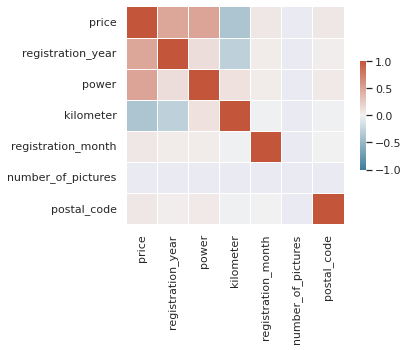

In [137]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

По итогу обзора видно, что в данных есть пропуски в категориальных признаках `vehicle_type` - 10%, `gearbox` - 5%, `model` - 5%, `fuel_type` - 9%, `not_repaired` - 20%. Чтобы не терять данные заменим все пропуски на `no_info`, так как если человек при выкладке обявления не укажет информаию о машине это сильно повлияет на спрос и, следовательно, на цену.

Мультиколлинеарности не замечено. Выбросы были определены здравым смыслом и удалены из датасета

Также я считаю, что признаки `date_crawled`, `date_created`, `postal_code` и `last_seen` можно удалить, они не оказывают влияния на цену автомобиля.

In [138]:
df = df.fillna('unknown')

In [139]:
df = df.drop(['date_crawled', 'date_created', 'postal_code', 'last_seen', 
              'registration_month', 'number_of_pictures'], axis=1)

Для дальнейшего обучения моделей важно закодировать категориальные признаки, однако оставим оригинальный датасет для бустинга

In [140]:
enc = OrdinalEncoder()
df_wc = df.copy()
df[cat_features] = enc.fit_transform(df[cat_features])

In [141]:
for col in cat_features:
    df_wc[col] = df_wc[col].astype('category')

Разобьём данные на обучющую и тестовую выборки.

In [142]:
features_train, features_test, target_train, target_test = train_test_split(
    df.drop('price', axis=1), df.price, test_size=0.25, random_state=42)

In [143]:
features_train_wc, features_test_wc, target_train_wc, target_test_wc = train_test_split(
    df_wc.drop('price', axis=1), df_wc.price, test_size=0.25, random_state=42)

Проведём масштабирование данных

In [144]:
numeric_features = ['registration_year', 'power', 'kilometer']

In [145]:
pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features_train_wc[numeric_features])
features_train_wc[numeric_features] = scaler.transform(features_train_wc[numeric_features])
features_test_wc[numeric_features] = scaler.transform(features_test_wc[numeric_features])

In [146]:
scaler = StandardScaler()
scaler.fit(features_train[numeric_features])
features_train = scaler.transform(features_train[numeric_features])
features_test = scaler.transform(features_test[numeric_features])

In [147]:
display(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(220971, 3)

(73657, 3)

(220971,)

(73657,)

In [148]:
display(features_train_wc.shape, features_test_wc.shape, target_train_wc.shape, target_test_wc.shape)

(220971, 9)

(73657, 9)

(220971,)

(73657,)

## Обучение моделей

### Dummy Regressor

In [149]:
start_time = time.time()

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)

end_time = time.time()
compare_data[0].append( round(end_time - start_time, 2))

In [150]:
start_time = time.time()

dummy_pred = dummy_regr.predict(features_test)

end_time = time.time()
compare_data[0].append(round(end_time - start_time, 2))

In [151]:
compare_data[0].append(round(rmse(target_test, dummy_pred),2))

### Linear Regression

In [152]:
model_reg = LinearRegression()

In [153]:
start_time = time.time()

model_reg.fit(features_train, target_train)

end_time = time.time()
compare_data[1].append(round(end_time - start_time, 2))

In [154]:
start_time = time.time()

reg_pred = model_reg.predict(features_test)

end_time = time.time()
compare_data[1].append(round(end_time - start_time, 2))

In [155]:
compare_data[1].append(round(rmse(target_test, reg_pred), 2))

### Decision Tree Regressor

In [156]:
start_time = time.time()

clf_tree = DecisionTreeRegressor(random_state=42)
parametrs_tree = {'max_depth': range (1, 32, 4)}
grid_tree = GridSearchCV(clf_tree, parametrs_tree, cv=5, verbose=1, n_jobs=-1, scoring=rmse_scorer)
grid_tree.fit(features_train, target_train)
print('Лучший средний RMSE на обучающей выборке:', -round(grid_tree.best_score_, 2), ', для модели с параметрами:', grid_tree.best_params_)

model_tree = DecisionTreeRegressor(random_state=42, max_depth = grid_tree.best_params_['max_depth'])
model_tree.fit(features_train, target_train)

end_time = time.time()
compare_data[2].append(round(end_time - start_time, 2))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучший средний RMSE на обучающей выборке: 2118.22 , для модели с параметрами: {'max_depth': 13}


In [157]:
start_time = time.time()

tree_pred = model_tree.predict(features_test)

end_time = time.time()
compare_data[2].append(round(end_time - start_time, 2))

In [158]:
compare_data[2].append(round(rmse(target_test, tree_pred), 2))

### Random Forest Regressor

In [159]:
start_time = time.time()

clf_forest = RandomForestRegressor(random_state=42)
parametrs_forest = {'n_estimators': range (1, 20, 5), 'max_depth': range (1, 8, 1)}
grid_forest = GridSearchCV(clf_forest, parametrs_forest, cv=5, verbose=10, n_jobs=-1, scoring=rmse_scorer)
grid_forest.fit(features_train, target_train)
grid_forest.best_params_
print('Лучший средний RMSE на обучающей выборке:', -round(grid_forest.best_score_, 2), ', для модели с параметрами:', grid_forest.best_params_)

model_forest = RandomForestRegressor(random_state=42, max_depth = grid_forest.best_params_['max_depth'], n_estimators = grid_forest.best_params_['n_estimators'])
model_forest.fit(features_train, target_train)

end_time = time.time()
compare_data[3].append(round(end_time - start_time, 2))

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Лучший средний RMSE на обучающей выборке: 2187.72 , для модели с параметрами: {'max_depth': 7, 'n_estimators': 16}


In [160]:
start_time = time.time()

forest_pred = model_forest.predict(features_test)

end_time = time.time()
compare_data[3].append(round(end_time - start_time, 2))

In [161]:
compare_data[3].append(round(rmse(target_test, forest_pred), 2))

### CatBoost

In [162]:
model_cat = CatBoostRegressor(loss_function="RMSE", iterations=200)

In [163]:
start_time = time.time()

model_cat.fit(features_train_wc, target_train_wc, verbose=10, cat_features=cat_features)

end_time = time.time()
compare_data[4].append(round(end_time - start_time, 2))

Learning rate set to 0.355506
0:	learn: 3583.9651335	total: 327ms	remaining: 1m 5s
10:	learn: 1920.8136123	total: 3.07s	remaining: 52.7s
20:	learn: 1795.6124841	total: 7.29s	remaining: 1m 2s
30:	learn: 1743.4222238	total: 9.4s	remaining: 51.2s
40:	learn: 1709.4136500	total: 11.6s	remaining: 45.1s
50:	learn: 1682.3426565	total: 14s	remaining: 40.8s
60:	learn: 1663.2209833	total: 16.3s	remaining: 37.1s
70:	learn: 1647.4049285	total: 20.1s	remaining: 36.4s
80:	learn: 1634.2704852	total: 23.1s	remaining: 34s
90:	learn: 1622.9531359	total: 25.4s	remaining: 30.5s
100:	learn: 1610.4488885	total: 27.7s	remaining: 27.1s
110:	learn: 1602.5023666	total: 30.7s	remaining: 24.6s
120:	learn: 1593.5687729	total: 34.1s	remaining: 22.3s
130:	learn: 1584.1035441	total: 37.6s	remaining: 19.8s
140:	learn: 1578.2103835	total: 39.9s	remaining: 16.7s
150:	learn: 1570.3746827	total: 42.1s	remaining: 13.7s
160:	learn: 1565.2924294	total: 44.3s	remaining: 10.7s
170:	learn: 1559.9076432	total: 46.6s	remaining: 7.

In [164]:
start_time = time.time()

cat_pred = model_cat.predict(features_test_wc)

end_time = time.time()
compare_data[4].append(round(end_time - start_time, 2))

In [165]:
compare_data[4].append(round(rmse(target_test, cat_pred), 2))

### LightGBM

In [166]:
model_lgbm = LGBMRegressor()

In [167]:
start_time = time.time()

model_lgbm.fit(features_train_wc, target_train_wc)

end_time = time.time()
compare_data[5].append(round(end_time - start_time, 2))

In [168]:
start_time = time.time()

lgbm_pred = model_lgbm.predict(features_test_wc)

end_time = time.time()
compare_data[5].append(round(end_time - start_time, 2))

In [169]:
compare_data[5].append(round(rmse(target_test, lgbm_pred), 2))

## Анализ моделей

In [170]:
index = ['Dummy Regressor', 'Linear Regression', 'Decision Tree Regressor', 'Random Forest Regressor', 
        'CatBoost', 'LightGBM']
columns = ['Время обучения', 'Скорость предсказания', 'Качество предсказания']

compare = pd.DataFrame(compare_data, index, columns).sort_values('Качество предсказания')

In [171]:
compare

,Время обучения,Скорость предсказания,Качество предсказания
LightGBM,1.88,0.47,1597.94
CatBoost,56.57,0.17,1602.70
Decision Tree Regressor,18.33,0.05,2108.20
Random Forest Regressor,86.33,0.10,2200.51
Linear Regression,0.09,0.02,3144.79
Dummy Regressor,0.00,0.00,4601.66


Итого: победитель LightGBM с результатом RMSE в 1598.47 и временем на обучение 28.03. Утешительный приз достаётся Dummy.